In [1]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [3]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

120

In [4]:
# data record example
data[0]

{'id': 'w9mlwz',
 'title': 'The "What happened in your state last week?" Megathread, Week 30',
 'text': 'Welcome to the \'What happened in your state last week\' thread, where you can post any local political news stories that you find important in the comments. This is a weekly thread posted every Monday, in order to facilitate more discussion on local issues on /r/politics. Since this is intended to be a thread about local politics, top-level comments that are exclusively about national issues will not be allowed. When commenting, please include the state you\'re living in, and don\'t forget to link sources. **Also, please actually describe what happened. Things like "I live in X, you know what happened", "Nothing happened" or "[Politician] continues to be an idiot" isn\'t helpful to users and will be removed.**\n\nIf someone from your state made a news round-up that you think is insufficient, feel free to comment to that round-up with further news stories. Enjoy discussion, and revi

In [5]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,"The ""What happened in your state last week?"" M..."
1,I’m Senator Ed Markey and I just introduced th...
2,Trump claims he has “absolute immunity” from J...
3,Democrats planning legislation to ban stock tr...
4,‘You just sentenced veterans to death’: Democr...
...,...
115,Justice Thomas no longer teaching courses at G...
116,DeSantis files complaint against Florida resta...
117,Schumer-Manchin reconciliation bill has $369 b...
118,West Virginia Punishes Banks That It Says Don’...


In [6]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,"The ""What happened in your state last week?"" M...",w9mlwz,Welcome to the 'What happened in your state la...,"Today in Illinois, the Highland Park shooter w...",Hopefully it's successful enough that they exp...
1,I’m Senator Ed Markey and I just introduced th...,wal6g5,PROOF: https://i.redd.it/124syk9z57e91.jpg\n\n...,"Hi everyone - as with all AMAs on /r/Politics,...",
2,Trump claims he has “absolute immunity” from J...,waacci,,"\nAs a reminder, this subreddit [is for civil ...","So far, for the last 76 years, Trump has opera..."
3,Democrats planning legislation to ban stock tr...,wa8rrx,,"\nAs a reminder, this subreddit [is for civil ...",I remember that Citizens United happened while...
4,‘You just sentenced veterans to death’: Democr...,wae19m,,"\nAs a reminder, this subreddit [is for civil ...",Navy Vet here-\n\nAlthough I'm one of the luck...
...,...,...,...,...,...
115,Justice Thomas no longer teaching courses at G...,w9pibc,,"\nAs a reminder, this subreddit [is for civil ...","I doubt it . He’s a Republican, this only feed..."
116,DeSantis files complaint against Florida resta...,wagfuo,,"\nAs a reminder, this subreddit [is for civil ...",Slippery slope Florida Investigates Bugs Bunny...
117,Schumer-Manchin reconciliation bill has $369 b...,wadph1,,"\nAs a reminder, this subreddit [is for civil ...",But it passed?\n\nWhats he gonna do? Claim the...
118,West Virginia Punishes Banks That It Says Don’...,wabr0e,,"\nAs a reminder, this subreddit [is for civil ...","Making WV poorer to own the libs, classic. Or,..."


In [7]:
new_stop_words=['one','subreddit', 'civil', 'u', 'gon', 'na','shill', 'troll',
                'actually','us','even']
# keywords occurring throughout all of the posts: clean up the text first
# text cleaning function: see prior class modules
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(new_stop_words)
# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [8]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,"The ""What happened in your state last week?"" M...",w9mlwz,Welcome to the 'What happened in your state la...,"Today in Illinois, the Highland Park shooter w...",Hopefully it's successful enough that they exp...,welcome happened state last week thread post l...
1,I’m Senator Ed Markey and I just introduced th...,wal6g5,PROOF: https://i.redd.it/124syk9z57e91.jpg\n\n...,"Hi everyone - as with all AMAs on /r/Politics,...",,proof hello reddit 2018 joined forced vote sen...
2,Trump claims he has “absolute immunity” from J...,waacci,,"\nAs a reminder, this subreddit [is for civil ...","So far, for the last 76 years, Trump has opera...",reminder discussion general courteous others m...
3,Democrats planning legislation to ban stock tr...,wa8rrx,,"\nAs a reminder, this subreddit [is for civil ...",I remember that Citizens United happened while...,reminder discussion general courteous others m...
4,‘You just sentenced veterans to death’: Democr...,wae19m,,"\nAs a reminder, this subreddit [is for civil ...",Navy Vet here-\n\nAlthough I'm one of the luck...,reminder discussion general courteous others m...
...,...,...,...,...,...,...
115,Justice Thomas no longer teaching courses at G...,w9pibc,,"\nAs a reminder, this subreddit [is for civil ...","I doubt it . He’s a Republican, this only feed...",reminder discussion general courteous others m...
116,DeSantis files complaint against Florida resta...,wagfuo,,"\nAs a reminder, this subreddit [is for civil ...",Slippery slope Florida Investigates Bugs Bunny...,reminder discussion general courteous others m...
117,Schumer-Manchin reconciliation bill has $369 b...,wadph1,,"\nAs a reminder, this subreddit [is for civil ...",But it passed?\n\nWhats he gonna do? Claim the...,reminder discussion general courteous others m...
118,West Virginia Punishes Banks That It Says Don’...,wabr0e,,"\nAs a reminder, this subreddit [is for civil ...","Making WV poorer to own the libs, classic. Or,...",reminder discussion general courteous others m...


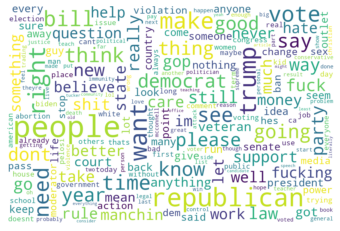

In [9]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=110,background_color="white", collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [10]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords 

{'happened': 62,
 'state': 267,
 'last': 56,
 'week': 39,
 'thread': 27,
 'post': 45,
 'local': 33,
 'political': 146,
 'stories': 13,
 'find': 118,
 'important': 70,
 'weekly': 1,
 'every': 189,
 'monday': 5,
 'order': 45,
 'facilitate': 1,
 'intended': 16,
 'exclusively': 4,
 'national': 32,
 'allowed': 71,
 'commenting': 4,
 'include': 36,
 'living': 46,
 'forget': 54,
 'link': 27,
 'describe': 8,
 'live': 169,
 'x': 12,
 'know': 522,
 'nothing': 228,
 'politician': 179,
 'idiot': 56,
 'helpful': 7,
 'removed': 44,
 'someone': 240,
 'made': 177,
 'think': 558,
 'insufficient': 4,
 'feel': 164,
 'free': 83,
 'enjoy': 14,
 'civility': 2,
 'guidelines': 2,
 'engaging': 7,
 'hi': 6,
 'reiterate': 2,
 'president': 208,
 'biden': 166,
 'figure': 31,
 'topic': 25,
 'thank': 71,
 'good': 438,
 'illinois': 4,
 'highland': 1,
 'park': 4,
 'shooter': 10,
 'indicted': 8,
 'felony': 9,
 'san': 2,
 'diego': 1,
 'starting': 34,
 'low': 50,
 'cost': 56,
 'daycare': 3,
 'center': 11,
 'police': 99,


In [11]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords.sort_values(by='count', ascending= False).head(15)

,count
keyword,
people,1065
republican,788
trump,705
right,629
vote,625
want,583
need,571
think,558
say,537


<AxesSubplot:xlabel='keyword'>

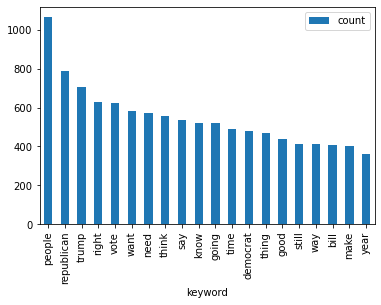

In [12]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(20).plot.bar()

In [13]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_posts['polarity'] = df_posts['text_clean'].apply(sentim_polarity)
df_posts['subjectivity'] = df_posts['text_clean'].apply(sentim_subject)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
0,"The ""What happened in your state last week?"" M...",w9mlwz,Welcome to the 'What happened in your state la...,"Today in Illinois, the Highland Park shooter w...",Hopefully it's successful enough that they exp...,welcome happened state last week thread post l...,0.155075,0.472677
1,I’m Senator Ed Markey and I just introduced th...,wal6g5,PROOF: https://i.redd.it/124syk9z57e91.jpg\n\n...,"Hi everyone - as with all AMAs on /r/Politics,...",,proof hello reddit 2018 joined forced vote sen...,0.123573,0.417698
2,Trump claims he has “absolute immunity” from J...,waacci,,"\nAs a reminder, this subreddit [is for civil ...","So far, for the last 76 years, Trump has opera...",reminder discussion general courteous others m...,0.033585,0.535831
3,Democrats planning legislation to ban stock tr...,wa8rrx,,"\nAs a reminder, this subreddit [is for civil ...",I remember that Citizens United happened while...,reminder discussion general courteous others m...,0.065188,0.520463
4,‘You just sentenced veterans to death’: Democr...,wae19m,,"\nAs a reminder, this subreddit [is for civil ...",Navy Vet here-\n\nAlthough I'm one of the luck...,reminder discussion general courteous others m...,-0.022615,0.496176
...,...,...,...,...,...,...,...,...
115,Justice Thomas no longer teaching courses at G...,w9pibc,,"\nAs a reminder, this subreddit [is for civil ...","I doubt it . He’s a Republican, this only feed...",reminder discussion general courteous others m...,0.109331,0.591015
116,DeSantis files complaint against Florida resta...,wagfuo,,"\nAs a reminder, this subreddit [is for civil ...",Slippery slope Florida Investigates Bugs Bunny...,reminder discussion general courteous others m...,0.005778,0.477695
117,Schumer-Manchin reconciliation bill has $369 b...,wadph1,,"\nAs a reminder, this subreddit [is for civil ...",But it passed?\n\nWhats he gonna do? Claim the...,reminder discussion general courteous others m...,0.217521,0.452723
118,West Virginia Punishes Banks That It Says Don’...,wabr0e,,"\nAs a reminder, this subreddit [is for civil ...","Making WV poorer to own the libs, classic. Or,...",reminder discussion general courteous others m...,-0.038656,0.522448


In [14]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [15]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [16]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('last', 'week'), 12),
 (('news', 'stories'), 3),
 (('things', 'like'), 12),
 (('president', 'biden'), 8),
 (('dan', 'cox'), 3),
 (('marijuana', 'legalization'), 3),
 (('would', 'need'), 10),
 (('last', 'years'), 6),
 (('minimum', 'wage'), 8),
 (('supreme', 'court'), 158),
 (('quick', 'question'), 3),
 (('question', 'seem'), 3),
 (('seem', 'sizable'), 3),
 (('sizable', 'difference'), 3),
 (('difference', 'left'), 3),
 (('left', 'right'), 22),
 (('right', 'media'), 3),
 (('media', 'outlets'), 126),
 (('outlets', 'feel'), 3),
 (('feel', 'like'), 55),
 (('like', 'difference'), 3),
 (('difference', 'seems'), 3),
 (('seems', 'like'), 64),
 (('like', '10'), 4),
 (('10', '1'), 3),
 (('1', 'sometimes'), 3),
 (('sometimes', 'yet'), 3),
 (('yet', 'average'), 3),
 (('average', 'majority'), 3),
 (('majority', 'polls'), 3),
 (('polls', 'seems'), 3),
 (('seems', 'show'), 3),
 (('show', 'around'), 3),
 (('around', 'difference'), 3),
 (('difference', 'missrepresentation'), 3),
 (('missrepresentation

In [17]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq.sort_values(by='count', ascending = False).head(20)

,count
keyphrase,
supreme court,158
media outlets,126
attack people,121
want help,120
better place,120
hate speech,119
bot action,118
community better,118
place consider,118


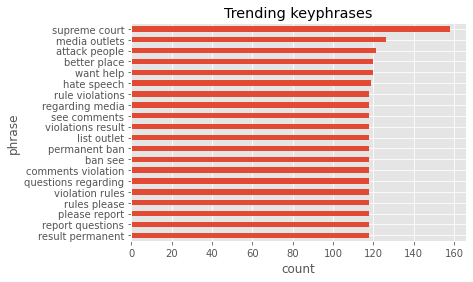

In [18]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()

In [19]:
# define the list of brands to analyze, consistent with the search topic
#  for which the tweets were collected
politics = ['republican', 'trump', 'biden', 'democrat', 'vote', 'people', 'bill','people',
           'supreme court', 'media outlets', 'attack people', 'better place', 'hate speech']
# start a brand comparison dataframe
df_politics = pd.DataFrame(politics, columns=['politics'])
df_politics

,politics
0,republican
1,trump
2,biden
3,democrat
4,vote
5,people
6,bill
7,people
8,supreme court
9,media outlets


In [20]:
# function to compute average sentiment of comments in reddit mentioning a given word
def politics_sentiment(b):
    return df_posts[df_posts['text_clean'].str.contains(b)]['polarity'].mean()

In [21]:
# politics sentiment comparison
df_politics['average_sentiment'] = df_politics['politics'].apply(politics_sentiment)
df_politics

,politics,average_sentiment
0,republican,0.049115
1,trump,0.038438
2,biden,0.053631
3,democrat,0.052341
4,vote,0.058496
5,people,0.056080
6,bill,0.050813
7,people,0.056080
8,supreme court,0.048389
9,media outlets,0.056345
